<a href="https://colab.research.google.com/github/mMitsu0/predicao_dengue/blob/main/tcc_monografia_grupo_gamma/f01_codes_modeling/dengue_previs%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **CENTRO UNIVERSITÁRIO NOSSA SENHORA DO PATROCÍNIO (CEUNSP)**
SALTO - SP

**BARACHELADO EM CIÊNCIA DA COMPUTAÇÕES**

# ***Análise Comparativa de Algoritmos de Machine Learning para Predição de Casos de Dengue.***

Autores:
*Matheus Mitsuo Tomotake Santos - RGM: 30248531*
*Pedro Gavioli Pinarde - RGM: 25798006*
*Lucas Felix Nogueira -RGM: 28851994*
*Gabriel Souza Cavalcante: RGM - 30386730*

**IMPORT DAS BIBLIOTECAS NECESSÁRIAS**

In [18]:
# === Utilidades do sistema e dados ===
import os  # Interações com o sistema operacional (ex: manipulação de arquivos e diretórios)
import pandas as pd  # Manipulação e análise de dados em tabelas (DataFrames)
import numpy as np  # Operações matemáticas e numéricas eficientes com arrays

# === Visualização de dados ===
import matplotlib.pyplot as plt  # Criação de gráficos e visualizações personalizadas
import seaborn as sns  # Visualizações estatísticas com design aprimorado

# === Requisições e manipulação de arquivos ===
import requests  # Requisições HTTP para acessar APIs e baixar dados
from io import StringIO  # Permite tratar strings como arquivos (útil para ler CSVs diretamente da web)

# === Machine Learning Clássico ===
from sklearn.model_selection import train_test_split  # Divisão dos dados em conjuntos de treino e teste
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor  # Modelos baseados em árvores de decisão
from sklearn.linear_model import LinearRegression  # Modelo de regressão linear tradicional
from xgboost import XGBRegressor  # Modelo de regressão baseado em boosting com alta performance
from sklearn.metrics import mean_squared_error, r2_score  # Métricas de avaliação (MSE e R²)
from sklearn.preprocessing import StandardScaler  # Normalização e padronização de variáveis (features)

# === Deep Learning (LSTM) ===
import tensorflow as tf  # Biblioteca de aprendizado profundo
from tensorflow.keras import layers, models, callbacks, optimizers  # Componentes do Keras para redes neurais LSTM

# === Configuração de ambiente (para Jupyter) ===
try:
    get_ipython().run_line_magic("matplotlib", "inline")  # Exibe gráficos diretamente no notebook
except:
    pass  # Ignora se não estiver em ambiente Jupyter


**CONEXÃO COM A API E DOWNLOAD DOS DADOS**

In [19]:
# === IMPORTS ===
import os  # Interações com o sistema operacional (ex: criar pastas)
import requests  # Requisições HTTP (para baixar dados da API InfoDengue)
import pandas as pd  # Manipulação e análise de dados tabulares
from io import StringIO  # Permite tratar strings como arquivos (útil para ler CSV direto da API)
from datetime import datetime  # Controle de datas (para definir ano atual automaticamente)

# ===============================================================
# === 1. DOWNLOAD DOS DADOS ===
# ===============================================================

# Dicionário com códigos IBGE das capitais brasileiras (usados na API InfoDengue)
estados_ibge = {
    "AC": [1200401], "AL": [2704302], "AM": [1302603], "AP": [1600303],
    "BA": [2927408], "CE": [2304400], "DF": [5300108], "ES": [3205309],
    "GO": [5208707], "MA": [2111300], "MG": [3106200], "MS": [5002704],
    "MT": [5103403], "PA": [1501402], "PB": [2507507], "PE": [2611606],
    "PI": [2211001], "PR": [4106902], "RJ": [3304557], "RN": [2408102],
    "RO": [1100205], "RR": [1400100], "RS": [4314902], "SC": [4205407],
    "SE": [2800308], "SP": [3550308], "TO": [1721000]
}

def baixar_dados_por_estado(diretorio_saida="data/raw", ano_inicio=2001, ano_fim=None):
    """
    Função responsável por baixar dados de dengue do InfoDengue
    para todas as capitais brasileiras, entre anos definidos.

    Parâmetros:
    - diretorio_saida (str): caminho onde o CSV final será salvo.
    - ano_inicio (int): primeiro ano da série temporal a ser coletada.
    - ano_fim (int | None): último ano da série; se None, usa o ano atual.
    """

    # Cria a pasta de destino caso não exista
    os.makedirs(diretorio_saida, exist_ok=True)

    # URL base da API InfoDengue
    base_url = "https://info.dengue.mat.br/api/alertcity"

    # Lista para armazenar os DataFrames de cada estado
    dfs = []

    # Define o ano final como o ano atual caso não seja informado
    if ano_fim is None:
        ano_fim = datetime.now().year

    # Loop sobre todos os estados e seus respectivos códigos IBGE
    for estado, municipios in estados_ibge.items():
        for geocode in municipios:

            # Monta os parâmetros da requisição
            params = {
                "geocode": geocode,
                "disease": "dengue",
                "format": "csv",
                "ew_start": 1,
                "ew_end": 52,
                "ey_start": ano_inicio,
                "ey_end": ano_fim
            }

            # Constrói a URL final da requisição
            url = f"{base_url}?{'&'.join([f'{k}={v}' for k,v in params.items()])}"

            try:
                # Envia requisição HTTP
                response = requests.get(url)

                # Verifica se a resposta foi bem-sucedida
                if response.status_code == 200:
                    # Lê o conteúdo CSV direto da resposta e cria um DataFrame
                    df = pd.read_csv(StringIO(response.text))
                    df["estado"] = estado
                    df["codigo_ibge"] = geocode
                    dfs.append(df)
                    print(f"✓ Dados coletados para {estado} ({ano_inicio}-{ano_fim})")
                else:
                    print(f" Falha ao coletar {estado} - status {response.status_code}")

            except Exception as e:
                print(f" Erro ao processar {estado}: {e}")

    # Após o loop, junta todos os DataFrames e salva em um único CSV
    if dfs:
        df_final = pd.concat(dfs, ignore_index=True)
        caminho_csv = f"{diretorio_saida}/dengue_{ano_inicio}_{ano_fim}_por_estado.csv"
        df_final.to_csv(caminho_csv, index=False)
        print(f"\n Dados salvos com sucesso em: {caminho_csv}")
    else:
        print(" Nenhum dado foi coletado.")

**REFINAMENTO DOS DADOS / FEATURES**

In [20]:
# ===============================================================
# === 2. ENGENHARIA DE FEATURES ===
# ===============================================================
# Objetivo: preparar os dados brutos para uso em modelos de Machine Learning.
# As etapas incluem limpeza, criação de variáveis temporais e remoção de outliers.
# ===============================================================

def carregar_e_limpar(caminho_arquivo):
    """
    Carrega o arquivo CSV contendo os dados de dengue e retorna um DataFrame.

    Parâmetros:
    - caminho_arquivo (str): Caminho completo para o arquivo CSV.

    Retorna:
    - df (DataFrame): Dados carregados em formato pandas.
    """
    return pd.read_csv(caminho_arquivo)


def adicionar_variaveis_temporais(df):
    """
    Adiciona colunas temporais e variáveis derivadas ao DataFrame.

    - Converte a coluna 'data_iniSE' para o formato datetime.
    - Cria colunas de ano e semana epidemiológica.
    - Cria variáveis defasadas (lags) de 1, 2 e 3 semanas.
    - Calcula a média móvel de 3 semanas dos casos.

    Parâmetros:
    - df (DataFrame): Dados originais com a coluna 'data_iniSE' e 'casos'.

    Retorna:
    - df (DataFrame): Dados com as novas colunas de engenharia temporal.
    """
    # Conversão da data para formato datetime
    df['data_iniSE'] = pd.to_datetime(df['data_iniSE'])

    # Criação das variáveis temporais
    df['epidemiological_year'] = df['data_iniSE'].dt.year
    df['epidemiological_week'] = df['data_iniSE'].dt.isocalendar().week

    # Criação de variáveis de defasagem (lags)
    df['casos_lag_1'] = df['casos'].shift(1)
    df['casos_lag_2'] = df['casos'].shift(2)
    df['casos_lag_3'] = df['casos'].shift(3)

    # Média móvel dos 3 lags (captura tendência recente)
    df['casos_media_3'] = df[['casos_lag_1', 'casos_lag_2', 'casos_lag_3']].mean(axis=1)

    return df


def remover_outliers(df, features):
    """
    Remove valores extremos (outliers) das variáveis especificadas.

    O método utilizado é baseado no IQR (Interquartile Range),
    removendo valores que estejam fora do intervalo [Q1 - 1.5*IQR, Q3 + 1.5*IQR].

    Parâmetros:
    - df (DataFrame): Conjunto de dados original.
    - features (list): Lista de colunas numéricas para aplicar o filtro.

    Retorna:
    - df (DataFrame): Conjunto de dados sem outliers nas features selecionadas.
    """
    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        df = df[(df[feature] >= Q1 - 1.5 * IQR) & (df[feature] <= Q3 + 1.5 * IQR)]
    return df


**MODELOS DE PREDIÇÃO**

In [21]:
# ===============================================================
# === 3.1 MODELOS MACHINE LEARNING (CLÁSSICOS) ===
# ===============================================================
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd


def treinar_modelos_classicos(
    X: np.ndarray,
    y: np.ndarray,
    test_size: float = 0.2,
    random_state: int = 42
):
    """
    Treina quatro modelos de ML clássico (Linear Regression, Random Forest,
    Gradient Boosting e XGBoost) e retorna métricas de desempenho.

    Parâmetros
    ----------
    X : np.ndarray
        Matriz de features (n_amostras x n_features).
    y : np.ndarray
        Vetor alvo (n_amostras,).
    test_size : float, default=0.2
        Proporção dos dados reservada para teste.
    random_state : int, default=42
        Semente para reprodutibilidade.

    Retorna
    -------
    resultados : dict
        Dicionário {nome_modelo: (mse, rmse, r2, nrmse_pct)}.
    modelos_treinados : dict
        Dicionário {nome_modelo: instancia_treinada}.
    """
    # Split estratificado não se aplica a regressão; usamos split simples
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Conjunto de modelos base com configurações reprodutíveis
    modelos = {
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(
            n_estimators=300,
            random_state=random_state,
            n_jobs=-1
        ),
        "Gradient Boosting": GradientBoostingRegressor(
            random_state=random_state
        ),
        "XGBoost": XGBRegressor(
            random_state=random_state,
            n_estimators=600,
            learning_rate=0.05,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=1.0,
            tree_method="hist",   # mais rápido; use "gpu_hist" se houver GPU
        ),
    }

    resultados = {}
    modelos_treinados = {}

    # Treinamento e avaliação padronizados
    for nome, modelo in modelos.items():
        # Para XGBoost podemos usar early stopping de forma segura
        if isinstance(modelo, XGBRegressor):
            modelo.fit(
                X_train, y_train,
                eval_set=[(X_test, y_test)],
                verbose=False,
                early_stopping_rounds=50
            )
        else:
            modelo.fit(X_train, y_train)

        # Predição e métricas
        y_pred = modelo.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = float(np.sqrt(mse))
        r2 = r2_score(y_test, y_pred)
        media_y = float(np.mean(y_test))
        nrmse_pct = (rmse / media_y * 100.0) if media_y != 0 else np.nan

        resultados[nome] = (mse, rmse, r2, nrmse_pct)
        modelos_treinados[nome] = modelo

    return resultados, modelos_treinados


def resultados_para_dataframe(resultados: dict) -> pd.DataFrame:
    """
    Converte o dicionário de métricas em um DataFrame ordenado por RMSE.
    """
    colunas = ["Modelo", "MSE", "RMSE", "R2", "NRMSE_%"]
    linhas = [
        [nome, *metricas] for nome, metricas in resultados.items()
    ]
    df_res = pd.DataFrame(linhas, columns=colunas)
    return df_res.sort_values("RMSE").reset_index(drop=True)


In [22]:
# ===============================================================
# === 3.2 LSTM — Modelagem Sequencial por Estado (multi-séries) ===
# ===============================================================
# Ideia central:
# 1) Ordenar dados por (estado, ano, semana) e montar janelas (lookback) -> alvo (horizon).
# 2) Separar treino/teste por "cutoff" temporal (ano, semana).
# 3) Escalonar SOMENTE as features (usando apenas treino).
# 4) Treinar LSTM e avaliar com MSE, RMSE, R² e nRMSE (%).
# ===============================================================

import numpy as np
import pandas as pd
from datetime import date
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers


def _ord_from_year_week(y, w):
    """
    Gera um número ordenável no formato YYYYWW para facilitar ordenação temporal.
    Ex.: ano=2024, semana=5 -> 202405
    """
    return int(f"{int(y):04d}{int(w):02d}")


def _build_sequences_by_state(df, features, lookback=8, horizon=1):
    """
    Constrói janelas temporais 3D por estado:
    - Para cada estado (codigo_ibge), ordena no tempo e cria pares:
        X[t-lookback:t, features] -> y[t + horizon - 1]
    - Retorna:
        X: shape (n_amostras, lookback, n_features)
        y: shape (n_amostras,)

    Parâmetros:
    - df (DataFrame): deve conter colunas 'codigo_ibge', 'epidemiological_year',
                      'epidemiological_week' e 'casos', além de 'features'.
    - features (list[str]): nomes das colunas de entrada.
    - lookback (int): tamanho da janela temporal usada como entrada.
    - horizon (int): passo à frente a ser previsto (1 = próxima semana).

    Observação:
    - Só cria amostras quando existe histórico suficiente (len >= lookback + horizon).
    """
    X_list, y_list = [], []

    # Ordenação global por estado/tempo para consistência
    df = df.sort_values(["codigo_ibge", "epidemiological_year", "epidemiological_week"]).copy()

    for gid, g in df.groupby("codigo_ibge"):
        g = g.copy()
        # Índice temporal ordenável
        g["ord"] = g.apply(lambda r: _ord_from_year_week(r["epidemiological_year"], r["epidemiological_week"]), axis=1)
        g = g.sort_values("ord")

        # Arrays de entrada (features) e alvo (casos)
        feats_arr  = g[features].to_numpy(dtype=float)
        target_arr = g["casos"].to_numpy(dtype=float)

        # Pula estados com histórico insuficiente
        if len(g) < lookback + horizon:
            continue

        # Deslizamento temporal para gerar janelas
        for t in range(lookback, len(g) - horizon + 1):
            X_list.append(feats_arr[t - lookback:t])
            y_list.append(target_arr[t + horizon - 1])

    X = np.array(X_list)  # (n_amostras, lookback, n_features)
    y = np.array(y_list)  # (n_amostras,)
    return X, y


def _temporal_mask_by_cutoff(df, lookback, horizon, cutoff=(2025, 1)):
    """
    Gera uma máscara booleana (True para TREINO, False para TESTE) com base em um
    "corte" temporal (ano, semana). Qualquer amostra cujo alvo (y) ocorra em
    ord_target < ord_cut -> TREINO; caso contrário -> TESTE.

    Mantém o MESMO critério de varredura de _build_sequences_by_state para alinhar
    1:1 as posições das amostras em X/y com a máscara retornada.
    """
    ord_cut = _ord_from_year_week(*cutoff)
    mask_list = []

    # Ordena e repete a varredura por estado
    for gid, g in df.sort_values(["codigo_ibge", "epidemiological_year", "epidemiological_week"]).groupby("codigo_ibge"):
        g = g.copy()
        g["ord"] = g.apply(lambda r: _ord_from_year_week(r["epidemiological_year"], r["epidemiological_week"]), axis=1)
        g = g.sort_values("ord")

        if len(g) < lookback + horizon:
            continue

        ord_vec = g["ord"].to_numpy()
        for t in range(lookback, len(g) - horizon + 1):
            ord_target = ord_vec[t + horizon - 1]
            mask_list.append(ord_target < ord_cut)  # True -> treino; False -> teste

    mask = np.array(mask_list, dtype=bool)
    return mask


def treinar_lstm_separado(
    df_feat_sem_outliers: pd.DataFrame,
    features: list,
    lookback: int = 8,
    horizon: int = 1,
    cutoff_test: tuple = (2025, 1),
    epochs: int = 80,
    batch_size: int = 256,
    lr: float = 1e-3,
    verbose: int = 1
):
    """
    Treina uma LSTM em janelas temporais por estado (multi-séries agregadas).

    Parâmetros:
    - df_feat_sem_outliers: DataFrame já limpo/filtrado (sem outliers) contendo:
        ['codigo_ibge','epidemiological_year','epidemiological_week','casos'] + features
    - features: lista de colunas numéricas de entrada.
    - lookback: tamanho da janela temporal (semanas) usada como entrada.
    - horizon: horizonte de previsão em semanas (1 = próxima semana).
    - cutoff_test: (ano, semana) — tudo com alvo >= cutoff vai para TESTE.
    - epochs, batch_size, lr, verbose: hiperparâmetros do treinamento.

    Retorna:
    - resultados_lstm: dict {"LSTM": (mse_te, rmse_te, r2_te, nrmse_te)}
    - model_lstm: modelo Keras treinado.
    - scaler: StandardScaler ajustado sobre as features do TREINO (para reuso em produção).
    """

    # 0) Higiene: garantir numéricos e sem NaN nas features (ffill/bfill conservadora)
    df_seq = df_feat_sem_outliers.copy()
    df_seq[features] = df_seq[features].astype(float).fillna(method="ffill").fillna(method="bfill")
    df_seq["casos"] = df_seq["casos"].astype(float)

    # 1) Construir tensores 3D (amostras, lookback, n_features)
    X_all, y_all = _build_sequences_by_state(df_seq, features, lookback=lookback, horizon=horizon)
    if len(X_all) == 0:
        raise ValueError(
            "Não foi possível construir sequências para a LSTM. "
            "Verifique se há dados suficientes por estado (lookback + horizon)."
        )

    # 2) Máscara temporal alinhada (True = treino; False = teste)
    mask_train = _temporal_mask_by_cutoff(df_seq, lookback, horizon, cutoff=cutoff_test)
    if mask_train.shape[0] != X_all.shape[0]:
        raise RuntimeError(
            "Máscara temporal não alinhada com as sequências. "
            "Garanta que _build_sequences_by_state e _temporal_mask_by_cutoff percorrem os mesmos estados e janelas."
        )

    X_tr, y_tr = X_all[mask_train], y_all[mask_train]
    X_te, y_te = X_all[~mask_train], y_all[~mask_train]

    # 3) Escalonamento (apenas sobre TREINO) — reshape para 2D, ajusta, e volta pro 3D
    n_features = X_tr.shape[-1]
    scaler = StandardScaler()
    X_tr_2d = X_tr.reshape(-1, n_features)
    scaler.fit(X_tr_2d)  # fit apenas com treino

    X_tr_scaled = scaler.transform(X_tr_2d).reshape(X_tr.shape)
    X_te_scaled = scaler.transform(X_te.reshape(-1, n_features)).reshape(X_te.shape)

    # 4) Arquitetura LSTM simples e robusta para séries semanais
    def build_lstm(input_shape, lr=lr):
        inp = layers.Input(shape=input_shape)
        x = layers.LSTM(64, return_sequences=True)(inp)
        x = layers.Dropout(0.2)(x)
        x = layers.LSTM(32)(x)
        x = layers.Dense(16, activation="relu")(x)
        out = layers.Dense(1)(x)
        model = models.Model(inp, out)
        model.compile(optimizer=optimizers.Adam(learning_rate=lr), loss="mse")
        return model

    model_lstm = build_lstm((lookback, n_features), lr=lr)

    # Callbacks: early stopping + ajuste adaptativo da taxa de aprendizado
    early = callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_loss")
    plateau = callbacks.ReduceLROnPlateau(patience=5, factor=0.5, min_lr=1e-5, monitor="val_loss")

    # 5) Treinamento (validação interna só no treino — teste já foi separado temporalmente)
    hist = model_lstm.fit(
        X_tr_scaled, y_tr,
        validation_split=0.15,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early, plateau],
        verbose=verbose
    )

    # 6) Avaliação em TREINO e TESTE (métricas padrão)
    y_hat_tr = model_lstm.predict(X_tr_scaled, verbose=0).ravel()
    y_hat_te = model_lstm.predict(X_te_scaled, verbose=0).ravel()

    def _metrics(y_true, y_pred):
        mse  = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2   = r2_score(y_true, y_pred)
        nrmse_pct = (rmse / np.mean(y_true) * 100) if np.mean(y_true) != 0 else np.nan
        return mse, rmse, r2, nrmse_pct

    mse_tr, rmse_tr, r2_tr, nrmse_tr = _metrics(y_tr, y_hat_tr)
    mse_te, rmse_te, r2_te, nrmse_te = _metrics(y_te, y_hat_te)

    print("\n=== LSTM - Métricas (Treino) ===")
    print(f"MSE (u²): {mse_tr:,.2f} | RMSE: {rmse_tr:,.2f} | R²: {r2_tr*100:,.2f}% | nRMSE: {nrmse_tr:,.2f}%")
    print("=== LSTM - Métricas (Teste)  ===")
    print(f"MSE (u²): {mse_te:,.2f} | RMSE: {rmse_te:,.2f} | R²: {r2_te*100:,.2f}% | nRMSE: {nrmse_te:,.2f}%")

    resultados_lstm = {"LSTM": (mse_te, rmse_te, r2_te, nrmse_te)}
    return resultados_lstm, model_lstm, scaler


**PLOTAGEM E AVALIAÇÃO DOS MODELOS**

In [23]:
# ===============================================================
# === 4. VISUALIZAÇÃO DE COMPARAÇÃO DE ERROS ===
# ===============================================================
# Objetivo: comparar o desempenho (erro percentual) entre os modelos de ML
# e Deep Learning (LSTM) através de um gráfico de barras.
# ===============================================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_comparacao_erros(modelos, mse_percentuais):
    """
    Gera um gráfico de barras comparando o erro percentual (ex: nRMSE%) entre modelos.

    Parâmetros:
    - modelos (list[str]): nomes dos modelos (ex: ["Linear", "RF", "GB", "XGB", "LSTM"])
    - mse_percentuais (list[float]): erros normalizados em porcentagem (%)

    Retorna:
    - None (gera o gráfico com seaborn/matplotlib)
    """
    # Criação do DataFrame para o gráfico
    df = pd.DataFrame({"Modelo": modelos, "Erro (%)": mse_percentuais})

    # Tamanho e estilo da figura
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")

    # Gráfico de barras
    sns.barplot(
        data=df,
        x="Modelo",
        y="Erro (%)",
        hue="Modelo",
        palette="viridis",
        legend=False
    )

    # Título e rótulos
    plt.title("Erro Quadrático Médio Normalizado (%) por Modelo", fontsize=14, weight="bold")
    plt.ylabel("Erro (%)", fontsize=12)
    plt.xlabel("Modelos", fontsize=12)

    # Ajustes visuais
    plt.xticks(rotation=45)
    plt.grid(True, axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


**MAIN**

✓ Dados coletados para AC (2010-2025)
✓ Dados coletados para AL (2010-2025)
✓ Dados coletados para AM (2010-2025)
✓ Dados coletados para AP (2010-2025)
✓ Dados coletados para BA (2010-2025)
✓ Dados coletados para CE (2010-2025)
✓ Dados coletados para DF (2010-2025)
✓ Dados coletados para ES (2010-2025)
✓ Dados coletados para GO (2010-2025)
✓ Dados coletados para MA (2010-2025)
✓ Dados coletados para MG (2010-2025)
✓ Dados coletados para MS (2010-2025)
✓ Dados coletados para MT (2010-2025)
✓ Dados coletados para PA (2010-2025)
✓ Dados coletados para PB (2010-2025)
✓ Dados coletados para PE (2010-2025)
✓ Dados coletados para PI (2010-2025)
✓ Dados coletados para PR (2010-2025)
✓ Dados coletados para RJ (2010-2025)
✓ Dados coletados para RN (2010-2025)
✓ Dados coletados para RO (2010-2025)
✓ Dados coletados para RR (2010-2025)
✓ Dados coletados para RS (2010-2025)
✓ Dados coletados para SC (2010-2025)
✓ Dados coletados para SE (2010-2025)
✓ Dados coletados para SP (2010-2025)
✓ Dados cole

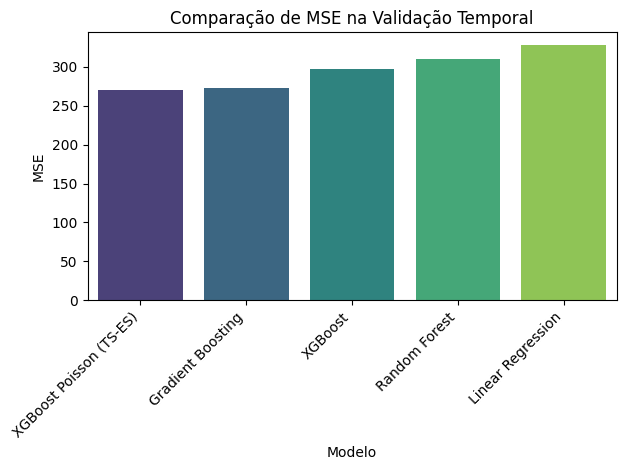

Epoch 1/120
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 36.0963 - val_loss: 28.7693 - learning_rate: 0.0010
Epoch 2/120
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 33.4648 - val_loss: 26.9960 - learning_rate: 0.0010
Epoch 3/120
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 28.6550 - val_loss: 25.0365 - learning_rate: 0.0010
Epoch 4/120
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 26.3660 - val_loss: 24.1657 - learning_rate: 0.0010
Epoch 5/120
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 24.8734 - val_loss: 23.8282 - learning_rate: 0.0010
Epoch 6/120
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 23.9592 - val_loss: 23.6964 - learning_rate: 0.0010
Epoch 7/120
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 23.4673 - val_loss: 23.6238 - learning_rate: 0.0010
Epoch 8/120
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 23.2700 - val_loss: 23.3142 - learning_rate: 0.0010
Epoch 9/120
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 22.4975 - val_loss: 21.1198 - learning_rate:

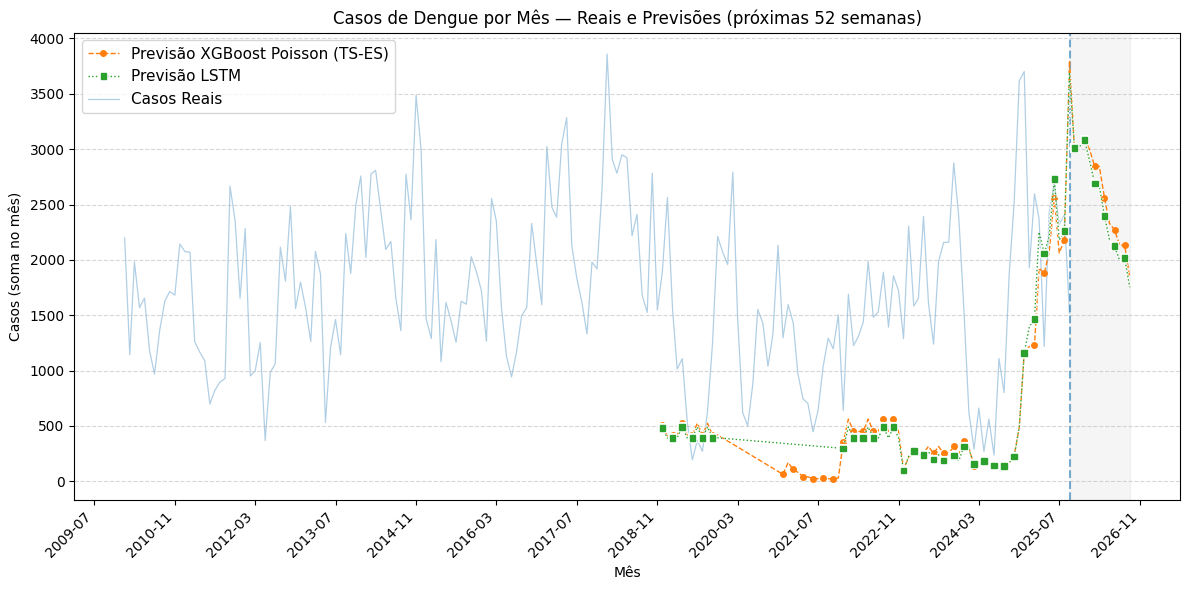

Gráficos semanais por UF salvos em: fig_semanais_por_uf/*.png


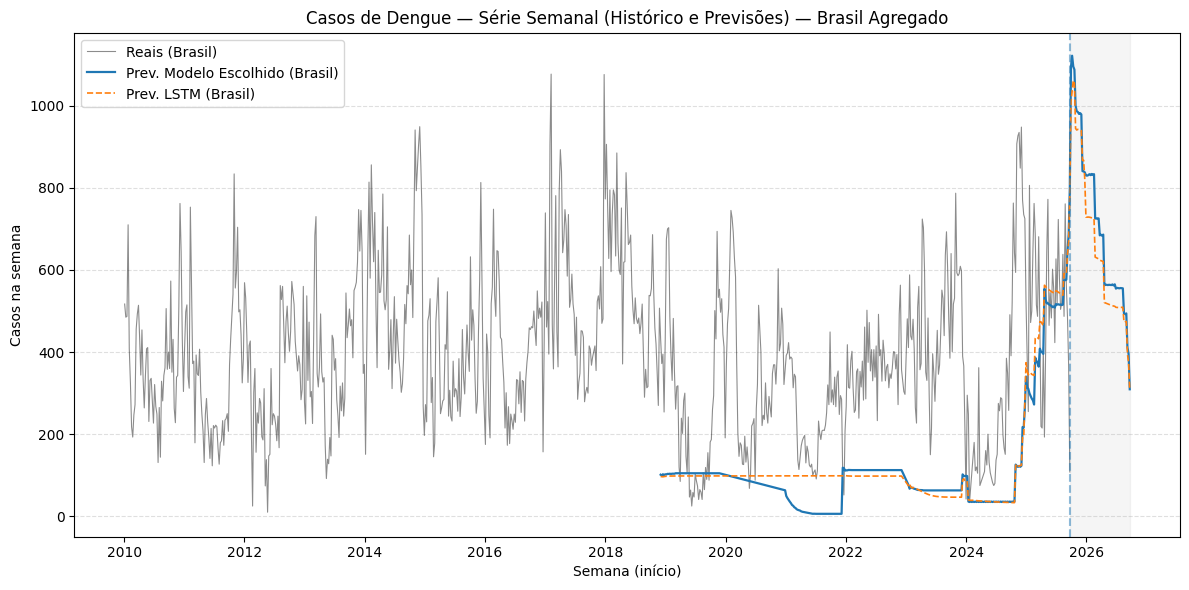

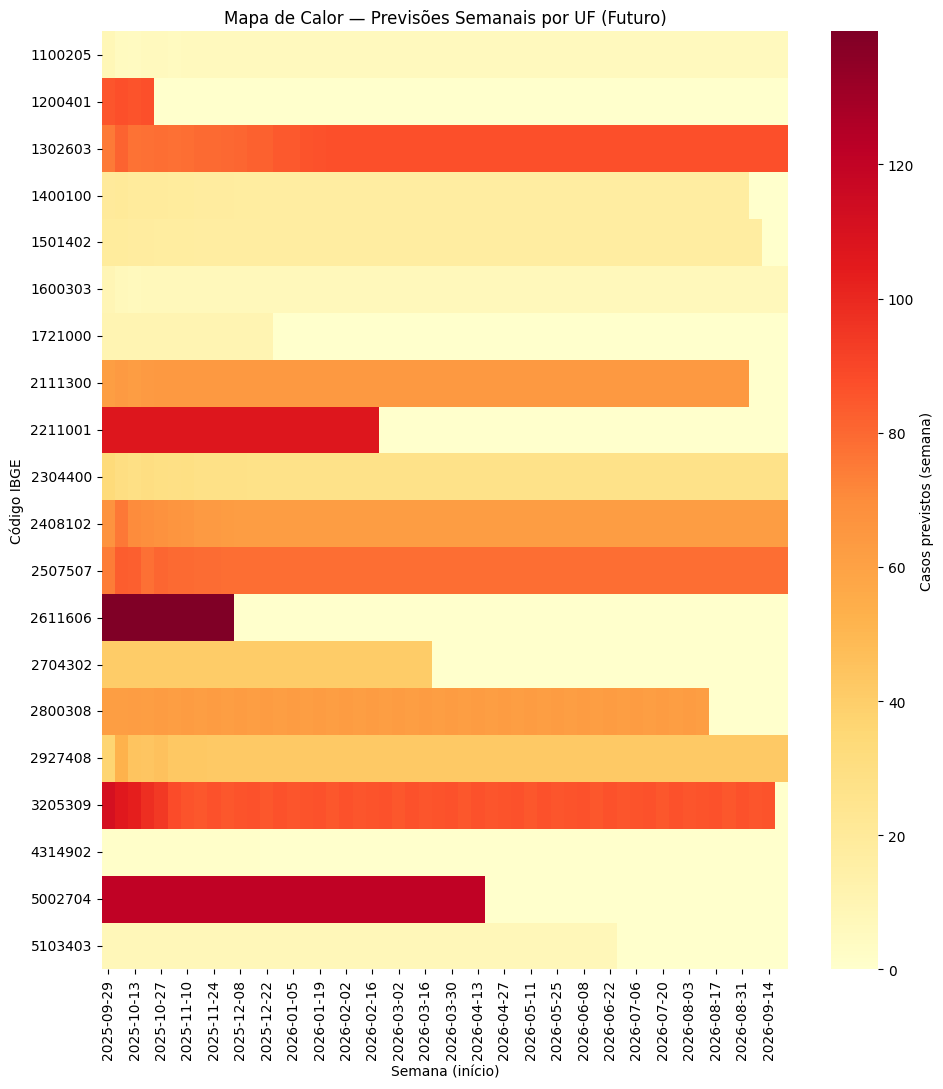

In [24]:
# ===============================================================
# === 5. EXECUÇÃO COMPLETA  (TS-SPLIT, XGB Poisson, LSTM e PLOT MENSAL) ===
# ===============================================================
# Este pipeline integra:
# 1) Download e preparação dos dados
# 2) Engenharia de features (lags, médias móveis, componentes sazonais)
# 3) Treinamento temporal de modelos clássicos (+ XGB Poisson com early stopping)
# 4) Treinamento LSTM em janelas por estado e previsão iterativa
# 5) Geração de previsões futuras (semanas -> agregação mensal) e plot
# Observação: requer as funções definidas previamente:
#   - baixar_dados_por_estado, carregar_e_limpar, adicionar_variaveis_temporais, remover_outliers
#   - treinar_lstm_separado (ou a versão abaixo já incluída no arquivo)
# ===============================================================

# --- Imports centrais do pipeline (redundantes caso já estejam no topo do seu script) ---
import os
from glob import glob
from datetime import date, timedelta, datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import matplotlib.dates as mdates

# xgboost
import xgboost as xgb
from xgboost import XGBRegressor

# modelos clássicos e métricas
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# LSTM
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.losses import Huber  # Perda robusta para lidar com outliers

# ---- (Opcional) Reprodutibilidade leve ----
import random
np.random.seed(42); random.seed(42); tf.random.set_seed(42)

# --------------------------
# Configuração de anos (um único range para todo o pipeline)
# --------------------------
ANO_INICIO = 2010
ANO_FIM    = 2025  # use year atual se preferir: datetime.now().year

# ====== Horizonte de previsão (semanas) ======
# 26 ≈ 6 meses | 52 ≈ 1 ano
N_FUTURO_SEMANAS = 52

# --------------------------
# Helpers gerais
# --------------------------
def yw_to_month_start(y, w):
    """Converte (ano ISO, semana ISO) no primeiro dia do mês correspondente.
       Resiliente à semana 53."""
    y, w = int(y), int(w)
    try:
        d = date.fromisocalendar(y, w, 1)
    except ValueError:
        d = date.fromisocalendar(y, 52, 1)  # fallback em anos sem iso-week 53
    return d.replace(day=1)

def _ord_from_year_week(y, w):
    """YYYYWW inteiro para ordenações/splits temporais."""
    return int(f"{int(y):04d}{int(w):02d}")

# ===== Engenharia de features rápida =====
def add_extra_features(df):
    """
    Cria lags de casos, média móvel de 3 semanas (usando SOMENTE passado)
    e componentes sazonais. Clima entra apenas com defasagens.
    """
    g = df.sort_values(["codigo_ibge","epidemiological_year","epidemiological_week"]).copy()

    # lags de casos (1..12)
    for lag in [1,2,3,4,8,12]:
        g[f"casos_lag_{lag}"] = g.groupby("codigo_ibge")["casos"].shift(lag)

    # MM3 SOMENTE do passado (previne vazamento)
    s = g.groupby("codigo_ibge")["casos"].shift(1)
    g["casos_mm3"] = s.rolling(3).mean().reset_index(level=0, drop=True)

    # sazonalidade
    w = g["epidemiological_week"].astype(float)
    g["week_sin"] = np.sin(2*np.pi*w/52.18)
    g["week_cos"] = np.cos(2*np.pi*w/52.18)

    # clima apenas defasado (se houver no dataset)
    if "tempmin" in g.columns:
        g["tempmin_lag1"] = g.groupby("codigo_ibge")["tempmin"].shift(1)
        g["tempmin_lag2"] = g.groupby("codigo_ibge")["tempmin"].shift(2)
    if "umidmax" in g.columns:
        g["umidmax_lag1"] = g.groupby("codigo_ibge")["umidmax"].shift(1)
        g["umidmax_lag2"] = g.groupby("codigo_ibge")["umidmax"].shift(2)

    return g

# --------------------------
# LSTM — construção de janelas e máscara temporal (versão local do bloco 3.2)
# --------------------------
def _build_sequences_by_state(df, features, lookback=8, horizon=1):
    """Monta tensores 3D (amostras, lookback, n_features) por estado."""
    X_list, y_list = [], []
    df = df.sort_values(["codigo_ibge","epidemiological_year","epidemiological_week"]).copy()
    for gid, g in df.groupby("codigo_ibge"):
        g = g.copy()
        g["ord"] = g.apply(lambda r: _ord_from_year_week(r["epidemiological_year"], r["epidemiological_week"]), axis=1)
        g = g.sort_values("ord")
        feats_arr = g[features].to_numpy(dtype=float)
        target_arr = g["casos"].to_numpy(dtype=float)
        if len(g) < lookback + horizon:
            continue
        for t in range(lookback, len(g) - horizon + 1):
            X_list.append(feats_arr[t - lookback:t])
            y_list.append(target_arr[t + horizon - 1])
    X = np.array(X_list); y = np.array(y_list)
    return X, y

def _temporal_mask_by_cutoff(df, lookback, horizon, cutoff=(2025,1)):
    """Máscara booleana alinhada às janelas: True=train; False=test, por cutoff ISO."""
    ord_cut = _ord_from_year_week(*cutoff)
    mask_list = []
    for gid, g in df.sort_values(["codigo_ibge","epidemiological_year","epidemiological_week"]).groupby("codigo_ibge"):
        g = g.copy()
        g["ord"] = g.apply(lambda r: _ord_from_year_week(r["epidemiological_year"], r["epidemiological_week"]), axis=1)
        g = g.sort_values("ord")
        if len(g) < lookback + horizon:
            continue
        ord_vec = g["ord"].to_numpy()
        for t in range(lookback, len(g) - horizon + 1):
            ord_target = ord_vec[t + horizon - 1]
            mask_list.append(ord_target < ord_cut)
    return np.array(mask_list, dtype=bool)

def treinar_lstm_separado(
    df_feat_sem_outliers,
    features,
    lookback=12,
    horizon=1,
    cutoff_test=(2025,1),
    epochs=120,
    batch_size=256,
    lr=1e-3,
    verbose=1
):
    """
    Treina LSTM agregando janelas de todas as capitais (multi-séries).
    Retorna métricas de teste, o modelo e o scaler para reuso em previsão.
    """
    df_seq = df_feat_sem_outliers.copy()
    df_seq[features] = df_seq[features].ffill().bfill()
    df_seq["casos"] = df_seq["casos"].astype(float)

    X_all, y_all = _build_sequences_by_state(df_seq, features, lookback=lookback, horizon=horizon)
    if len(X_all) == 0:
        raise ValueError("Sem dados suficientes para LSTM. Verifique lookback/horizon.")

    mask_train = _temporal_mask_by_cutoff(df_seq, lookback, horizon, cutoff=cutoff_test)
    if mask_train.shape[0] != X_all.shape[0]:
        raise RuntimeError("Máscara temporal desalinhada.")

    X_tr, y_tr = X_all[mask_train], y_all[mask_train]
    X_te, y_te = X_all[~mask_train], y_all[~mask_train]

    n_features = X_tr.shape[-1]
    scaler = StandardScaler()
    X_tr_2d = X_tr.reshape(-1, n_features)
    scaler.fit(X_tr_2d)
    X_tr_scaled = scaler.transform(X_tr_2d).reshape(X_tr.shape)
    X_te_scaled = scaler.transform(X_te.reshape(-1, n_features)).reshape(X_te.shape)

    def build_lstm(input_shape, lr=lr):
        inp = layers.Input(shape=input_shape)
        x = layers.LSTM(64, return_sequences=True)(inp)
        x = layers.Dropout(0.2)(x)
        x = layers.LSTM(32)(x)
        x = layers.Dense(16, activation="relu")(x)
        out = layers.Dense(1, activation="softplus")(x)  # saída positiva e suave
        model = models.Model(inp, out)
        model.compile(optimizer=optimizers.Adam(learning_rate=lr), loss=Huber(delta=1.0))
        return model

    model_lstm = build_lstm((lookback, n_features), lr=lr)
    early = callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_loss")
    plateau = callbacks.ReduceLROnPlateau(patience=5, factor=0.5, min_lr=1e-5, monitor="val_loss")

    model_lstm.fit(
        X_tr_scaled, y_tr,
        validation_split=0.15,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early, plateau],
        verbose=verbose
    )

    def _metrics(y_true, y_pred):
        mse = np.mean((y_true - y_pred) ** 2)
        rmse = float(np.sqrt(mse))
        ss_res = np.sum((y_true - y_pred) ** 2)
        ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
        r2 = 1 - ss_res / ss_tot if ss_tot != 0 else np.nan
        nrmse_pct = (rmse / np.mean(y_true)) * 100 if np.mean(y_true) != 0 else np.nan
        return mse, rmse, r2, nrmse_pct

    y_hat_tr = model_lstm.predict(X_tr_scaled, verbose=0).ravel()
    y_hat_te = model_lstm.predict(X_te_scaled, verbose=0).ravel()

    mse_tr, rmse_tr, r2_tr, nrmse_tr = _metrics(y_tr, y_hat_tr)
    mse_te, rmse_te, r2_te, nrmse_te = _metrics(y_te, y_hat_te)

    print("\n=== LSTM - Métricas (Treino) ===")
    print(f"MSE (u²): {mse_tr:,.2f} | RMSE: {rmse_tr:,.2f} | R²: {r2_tr*100:,.2f}% | nRMSE: {nrmse_tr:,.2f}%")
    print("=== LSTM - Métricas (Teste)  ===")
    print(f"MSE (u²): {mse_te:,.2f} | RMSE: {rmse_te:,.2f} | R²: {r2_te*100:,.2f}% | nRMSE: {nrmse_te:,.2f}%")

    resultados_lstm = {"LSTM": (mse_te, rmse_te, r2_te, nrmse_te)}
    return resultados_lstm, model_lstm, scaler, lookback

# ===== previsão LSTM para N semanas (genérica) =====
def prever_n_semanas_lstm(df_feat_sem_outliers, features, model_lstm, scaler, lookback, n_weeks=26):
    """
    Faz previsão iterativa semana-a-semana, por estado, atualizando lags compatíveis.
    Retorna DataFrame com colunas: codigo_ibge, epidemiological_year, epidemiological_week, casos_previstos_lstm
    """
    df = df_feat_sem_outliers.sort_values(["codigo_ibge","epidemiological_year","epidemiological_week"]).copy()
    last_windows = {}
    for gid, g in df.groupby("codigo_ibge"):
        if len(g) < lookback:
            continue
        last_windows[gid] = g.iloc[-lookback:].copy()

    fut_rows = []
    # índices em 'features' que precisam ser atualizados durante a simulação
    idx_lag1 = features.index("casos_lag_1") if "casos_lag_1" in features else None
    idx_med3 = features.index("casos_media_3") if "casos_media_3" in features else None

    for gid, win_df in last_windows.items():
        win_vals = win_df[features].to_numpy(dtype=float)  # (lookback, n_features)
        y_last = int(win_df.iloc[-1]["epidemiological_year"])
        w_last = int(win_df.iloc[-1]["epidemiological_week"])

        for _ in range(n_weeks):
            X_in = scaler.transform(win_vals)
            y_pred = float(model_lstm.predict(X_in[np.newaxis, ...], verbose=0).ravel()[0])
            y_pred = max(0.0, y_pred)
            # aplica teto FUT_CAP se definido globalmente
            if 'FUT_CAP' in globals() and FUT_CAP is not None:
                y_pred = min(y_pred, FUT_CAP)

            # atualiza lags/médias para a próxima janela
            new_row = win_vals[-1].copy()
            if idx_lag1 is not None:
                new_row[idx_lag1] = y_pred
            if idx_med3 is not None:
                last_lag1_series = win_vals[-2:, idx_lag1] if win_vals.shape[0] >= 2 else np.array([])
                vals = list(last_lag1_series) + [y_pred]
                new_row[idx_med3] = np.mean(vals)

            # avança 1 semana ISO
            d = date.fromisocalendar(y_last, w_last, 1) + timedelta(weeks=1)
            iso = d.isocalendar(); y_last, w_last = int(iso[0]), int(iso[1])

            fut_rows.append({
                "codigo_ibge": gid,
                "epidemiological_year": y_last,
                "epidemiological_week": w_last,
                "casos_previstos_lstm": y_pred
            })
            # janela deslizante
            win_vals = np.vstack([win_vals[1:], new_row])

    return pd.DataFrame(fut_rows)

# --------------------------
# Modelos clássicos com split temporal + XGB Poisson (early stopping)
# --------------------------
def treinar_modelos(X, y, ord_vec, val_weeks=8):
    """
    Split temporal: últimas `val_weeks` semanas constituem o conjunto de validação.
    ord_vec: vetor inteiro AAAASW alinhado a X,y.
    Retorna (resultados, modelos_treinados) com MSE e R².
    """
    # --- split temporal
    ords = np.sort(np.unique(ord_vec))
    val_ords = ords[-val_weeks:] if len(ords) > val_weeks else ords[-max(1, len(ords)//5):]
    mask_val = np.isin(ord_vec, val_ords)
    mask_tr  = ~mask_val

    X_tr, y_tr = X[mask_tr], y[mask_tr]
    X_val, y_val = X[mask_val], y[mask_val]

    # --- pesos temporais (levemente mais peso p/ recente)
    w_tr = time_weights(ord_vec[mask_tr], power=1.0)

    # --- modelos sklearn "clássicos"
    modelos = {
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(
            random_state=42, n_estimators=800, max_features="sqrt",
            max_depth=12, min_samples_leaf=5
        ),
        "Gradient Boosting": GradientBoostingRegressor(
            random_state=42, n_estimators=1000, learning_rate=0.05, max_depth=3
        ),
        "XGBoost": XGBRegressor(
            random_state=42, n_estimators=1500, learning_rate=0.03, max_depth=4,
            min_child_weight=5, subsample=0.9, colsample_bytree=0.9,
            reg_lambda=2.0, reg_alpha=0.1, tree_method="hist"
        ),
    }

    resultados, modelos_treinados = {}, {}

    for nome, modelo in modelos.items():
        try:
            modelo.fit(X_tr, y_tr, sample_weight=w_tr)
        except TypeError:
            modelo.fit(X_tr, y_tr)
        y_hat = modelo.predict(X_val)
        resultados[nome] = (mean_squared_error(y_val, y_hat), r2_score(y_val, y_hat))
        modelos_treinados[nome] = modelo

    # --- XGBoost Poisson com early stopping via xgb.train
    dtr  = xgb.DMatrix(X_tr, label=y_tr, weight=w_tr)
    dval = xgb.DMatrix(X_val, label=y_val)

    params = {
        "objective": "count:poisson",
        "eval_metric": "poisson-nloglik",
        "tree_method": "hist",
        "random_state": 42,
        "eta": 0.03,
        "max_depth": 6,
        "subsample": 0.9,
        "colsample_bytree": 0.9,
        "lambda": 1.0,
    }
    # Regularização adicional (mais conservador)
    params.update({"max_depth": 4, "min_child_weight": 5, "lambda": 2.0, "alpha": 0.1})

    booster = xgb.train(
        params,
        dtr,
        num_boost_round=5000,
        evals=[(dval, "val")],
        early_stopping_rounds=200,
        verbose_eval=False
    )

    class XGBPoissonWrapper:
        """Wrapper simples para manter interface .predict como nos modelos sklearn."""
        def __init__(self, booster):
            self.booster = booster
        def predict(self, X_):
            return self.booster.predict(xgb.DMatrix(X_))

    xgb_poisson_model = XGBPoissonWrapper(booster)
    y_hat_p = xgb_poisson_model.predict(X_val)

    resultados["XGBoost Poisson (TS-ES)"] = (mean_squared_error(y_val, y_hat_p), r2_score(y_val, y_hat_p))
    modelos_treinados["XGBoost Poisson (TS-ES)"] = xgb_poisson_model

    return resultados, modelos_treinados

# --------------------------
# Fluxo principal
# --------------------------

# Passo 1 — Download com o mesmo range usado no restante do pipeline
baixar_dados_por_estado(ano_inicio=ANO_INICIO, ano_fim=ANO_FIM)

# Passo 2 — Carregar o arquivo correto (com fallback se não existir)
caminho_csv = f"data/raw/dengue_{ANO_INICIO}_{ANO_FIM}_por_estado.csv"
if not os.path.exists(caminho_csv):
    candidatos = sorted(glob("data/raw/dengue_*_por_estado.csv"))
    if candidatos:
        print(f" Arquivo {caminho_csv} não encontrado. Usando {candidatos[-1]}")
        caminho_csv = candidatos[-1]
    else:
        raise FileNotFoundError("Nenhum CSV de dengue encontrado em data/raw/. Verifique o download.")

# Carrega e aplica engenharia básica
df = carregar_e_limpar(caminho_csv)
df_feat = adicionar_variaveis_temporais(df)
df_feat = add_extra_features(df_feat)  # novas features

# Preenche NaNs (lags iniciais e possíveis faltas de clima/população)
df_feat = df_feat.sort_values(["codigo_ibge","epidemiological_year","epidemiological_week"]).copy()
cols_to_fill = list(set([
    "casos",
    "casos_lag_1","casos_lag_2","casos_lag_3","casos_lag_4","casos_lag_8","casos_lag_12",
    "casos_mm3",
    "week_sin","week_cos",
    "pop","tempmin_lag1","tempmin_lag2","umidmax_lag1","umidmax_lag2",
    "receptivo","transmissao",
    "casos_media_3"
]))

for col in cols_to_fill:
    if col in df_feat.columns:
        df_feat[col] = df_feat.groupby("codigo_ibge")[col].transform(lambda s: s.ffill().bfill())

# Se "casos_media_3" não existia, cria a partir dos lags
if "casos_media_3" in df_feat.columns:
    mask_missing = df_feat["casos_media_3"].isna()
    if mask_missing.any():
        df_feat.loc[mask_missing, "casos_media_3"] = (
            df_feat.loc[mask_missing, ["casos_lag_1","casos_lag_2","casos_lag_3"]].mean(axis=1)
        )

# Seleção de features (inclui as novas criadas)
features = [
    # casos (somente lags)
    "casos_lag_1","casos_lag_2","casos_lag_3","casos_lag_4","casos_lag_8","casos_lag_12",
    # média móvel de 3 semanas (só passado)
    "casos_mm3",
    # sazonalidade
    "week_sin","week_cos",
    # variáveis externas APENAS defasadas
    "pop",
    "tempmin_lag1","tempmin_lag2","umidmax_lag1","umidmax_lag2",
    # variáveis do seu pipeline
    "receptivo","transmissao",
    # compatibilidade com rotina LSTM
    "casos_media_3"
]

# Remoção de outliers nas features (conforme seu bloco 2)
df_feat_sem_outliers = remover_outliers(df_feat, features)

# Vetor temporal para split/weights
ord_vec = (df_feat_sem_outliers["epidemiological_year"].astype(int)*100 +
           df_feat_sem_outliers["epidemiological_week"].astype(int)).values

# Matrizes de treino
X = df_feat_sem_outliers[features].values
y = df_feat_sem_outliers["casos"].values.astype(float)

# Teto de segurança para previsões futuras (evita explosões)
p98 = np.percentile(y[~np.isnan(y)], 98)
FUT_CAP = float(p98 * 1.25)

# Treino temporal + Early Stopping
resultados, modelos_treinados = treinar_modelos(X, y, ord_vec, val_weeks=8)

# Escolha automática do melhor (menor MSE)
modelo_escolhido_nome = min(resultados.keys(), key=lambda k: resultados[k][0])
modelo_escolhido = modelos_treinados[modelo_escolhido_nome]
print(f"\n>>> Modelo escolhido: {modelo_escolhido_nome}")

# ===== Avaliação (val temporal) — gráfico de MSE
df_mse = (
    pd.DataFrame([(k, v[0]) for k, v in resultados.items()], columns=["Modelo","MSE"])
      .sort_values("MSE")
)
sns.barplot(data=df_mse, x="Modelo", y="MSE", hue="Modelo", palette="viridis", legend=False)
plt.title("Comparação de MSE na Validação Temporal")
plt.ylabel("MSE"); plt.xlabel("Modelo"); plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()

# ===== Previsões no histórico (in-sample) com o modelo escolhido
df_feat_sem_outliers["casos_previstos_in_sample"] = np.clip(modelo_escolhido.predict(X), 0, None)

# ===== Função para avançar 1 semana ISO (vetorizado)
def advance_iso_week_vectorized(years, weeks):
    new_years, new_weeks = [], []
    for y_, w_ in zip(years, weeks):
        d = date.fromisocalendar(int(y_), int(w_), 1) + timedelta(weeks=1)
        iso = d.isocalendar()
        new_years.append(int(iso[0])); new_weeks.append(int(iso[1]))
    return pd.Series(new_years), pd.Series(new_weeks)

# ===== Preparação dos últimos registros por estado (seed de previsão)
ultimos_registros = (
    df_feat_sem_outliers
    .sort_values(["codigo_ibge","epidemiological_year","epidemiological_week"])
    .groupby("codigo_ibge").tail(1).copy()
)
# Garante colunas de lags fundamentais
for col in ["casos_lag_1","casos_lag_2","casos_lag_3","casos_media_3"]:
    if col not in ultimos_registros.columns:
        ultimos_registros[col] = np.nan
ultimos_registros["casos_lag_1"] = ultimos_registros["casos_lag_1"].fillna(ultimos_registros.get("casos", 0))
ultimos_registros["casos_lag_2"] = ultimos_registros["casos_lag_2"].fillna(ultimos_registros["casos_lag_1"])
ultimos_registros["casos_lag_3"] = ultimos_registros["casos_lag_3"].fillna(ultimos_registros["casos_lag_2"])
ultimos_registros["casos_media_3"] = ultimos_registros["casos_media_3"].fillna(
    ultimos_registros[["casos_lag_1","casos_lag_2","casos_lag_3"]].mean(axis=1)
)

# ===== Previsão de N_FUTURO_SEMANAS (modelo escolhido — iterativa)
previsoes_futuras = []

# ordem de atualização dos lags (do maior para o menor)
_LAG_ORDER = [12, 8, 4, 3, 2]  # lag_1 será o y_pred

for _ in range(N_FUTURO_SEMANAS):
    X_input = ultimos_registros[features].copy()

    # previsão com teto FUT_CAP
    y_pred = np.clip(modelo_escolhido.predict(X_input), 0, FUT_CAP)

    # === atualiza lags: lag_k <- lag_{k-1} ; lag_1 <- y_pred ===
    for k in _LAG_ORDER:
        src = 1 if k == 2 else (k - 1)  # para k=2, vem de lag_1; demais, padrão k-1
        ultimos_registros[f"casos_lag_{k}"] = ultimos_registros.get(f"casos_lag_{src}", ultimos_registros["casos_lag_1"])

    ultimos_registros["casos_lag_1"] = y_pred

    # === atualiza médias derivadas dos lags ===
    ultimos_registros["casos_media_3"] = ultimos_registros[["casos_lag_1","casos_lag_2","casos_lag_3"]].mean(axis=1)
    ultimos_registros["casos_mm3"]     = ultimos_registros["casos_media_3"]  # coerência com definição (média de 3 lags)

    # avança semana ISO
    new_years, new_weeks = advance_iso_week_vectorized(
        ultimos_registros["epidemiological_year"].values,
        ultimos_registros["epidemiological_week"].values
    )
    ultimos_registros["epidemiological_year"] = new_years.values
    ultimos_registros["epidemiological_week"] = new_weeks.values

    snap = ultimos_registros.copy()
    snap["casos_previstos"] = y_pred
    previsoes_futuras.append(snap)

df_previsoes_futuras = pd.concat(previsoes_futuras, ignore_index=True).assign(
    casos_previstos=lambda d: d["casos_previstos"].astype(float)
)

# ===== Treina LSTM e prevê N_FUTURO_SEMANAS
res_lstm, model_lstm, scaler_lstm, lookback = treinar_lstm_separado(
    df_feat_sem_outliers, features,
    lookback=12, horizon=1, cutoff_test=(2025,1),
    epochs=120, batch_size=256, lr=1e-3, verbose=1
)
df_previsoes_futuras_lstm = prever_n_semanas_lstm(
    df_feat_sem_outliers, features, model_lstm, scaler_lstm, lookback,
    n_weeks=N_FUTURO_SEMANAS
)

# ===== Agregação mensal (reais e previsões)
# Reais
real_m = df_feat_sem_outliers.copy()
real_m["mes_dt"] = real_m.apply(lambda r: yw_to_month_start(r["epidemiological_year"], r["epidemiological_week"]), axis=1)
real_m = real_m.groupby("mes_dt")["casos"].sum().reset_index().rename(columns={"casos":"Casos Reais"})

# Clássico escolhido
xgb_m = df_previsoes_futuras.copy()
xgb_m["mes_dt"] = xgb_m.apply(lambda r: yw_to_month_start(r["epidemiological_year"], r["epidemiological_week"]), axis=1)
xgb_m = xgb_m.groupby("mes_dt")["casos_previstos"].sum().reset_index().rename(columns={"casos_previstos":f"Previsão {modelo_escolhido_nome}"})

# LSTM
lstm_m = df_previsoes_futuras_lstm.copy()
lstm_m["mes_dt"] = lstm_m.apply(lambda r: yw_to_month_start(r["epidemiological_year"], r["epidemiological_week"]), axis=1)
lstm_m = lstm_m.groupby("mes_dt")["casos_previstos_lstm"].sum().reset_index().rename(columns={"casos_previstos_lstm":"Previsão LSTM"})

# Unifica e ordena
df_month = (real_m.merge(xgb_m, on="mes_dt", how="outer")
                  .merge(lstm_m, on="mes_dt", how="outer")
                  .sort_values("mes_dt"))

ultimo_mes_real = real_m["mes_dt"].max() if len(real_m) else None

# === Trilhos sazonais por mês (blend com mediana histórica + teto p90*1.10) ===
if len(real_m):
    real_hist = real_m[real_m["mes_dt"] <= ultimo_mes_real].copy() if ultimo_mes_real is not None else real_m.copy()
    real_hist["mes_num"] = pd.to_datetime(real_hist["mes_dt"]).dt.month
    saz = (real_hist
           .groupby("mes_num")["Casos Reais"]
           .agg(mediana="median", p90=lambda s: np.percentile(s, 90))
           .reset_index())
    saz_map = {int(r.mes_num): (float(r.mediana), float(r.p90) * 1.10)
               for r in saz.itertuples(index=False)}

    def aplica_trilhos(col):
        """Faz blend com a mediana do mês e aplica teto sazonal p90*1.10."""
        if col not in df_month.columns:
            return
        mask_fut = df_month["mes_dt"] > ultimo_mes_real if ultimo_mes_real is not None else df_month["mes_dt"] >= df_month["mes_dt"].min()
        if not mask_fut.any():
            return

        meses = pd.to_datetime(df_month.loc[mask_fut, "mes_dt"]).dt.month
        preds = df_month.loc[mask_fut, col].astype(float).values

        alpha = 0.60  # peso da previsão no blend (ajuste conforme calibragem desejada)
        blends = []
        for val, m in zip(preds, meses):
            med, cap = saz_map.get(int(m), (np.nan, np.nan))
            if not np.isfinite(med):
                med = np.nanmedian(preds)
            if not np.isfinite(cap):
                cap = np.nanpercentile(preds, 90) * 1.10
            b = alpha * val + (1 - alpha) * med   # aproxima da mediana sazonal
            b = min(b, cap)                        # teto sazonal
            blends.append(b)

        df_month.loc[mask_fut, col] = blends

    aplica_trilhos(f"Previsão {modelo_escolhido_nome}")
    aplica_trilhos("Previsão LSTM")

# === Suavização EMA no trecho futuro (deixa horizonte mais uniforme)
def _ema(series, alpha=0.35):
    vals = series.values.astype(float)
    if len(vals) == 0: return series
    out = np.empty_like(vals, dtype=float)
    out[0] = vals[0]
    for i in range(1, len(vals)):
        out[i] = alpha*vals[i] + (1-alpha)*out[i-1]
    return pd.Series(out, index=series.index)

if ultimo_mes_real is not None:
    mask_fut = df_month["mes_dt"] > ultimo_mes_real
    for col in [f"Previsão {modelo_escolhido_nome}", "Previsão LSTM"]:
        if col in df_month.columns:
            df_month.loc[mask_fut, col] = _ema(
                df_month.loc[mask_fut, col].ffill().bfill()
            )

# === PRINT: métricas por modelo (validação temporal) ===
print("\n=== Métricas por modelo (validação temporal) ===")
df_scores = (
    pd.DataFrame(
        [(nome, met[0], met[1]) for nome, met in resultados.items()],
        columns=["Modelo", "MSE", "R2"]
    )
    .sort_values("MSE")
)

# formatação bonita
with pd.option_context('display.float_format', lambda x: f'{x:,.4f}'):
    print(df_scores.to_string(index=False))

# também deixa claro o melhor pelo MSE
melhor_nome = df_scores.iloc[0, 0]
melhor_mse  = df_scores.iloc[0, 1]
print(f"\n>>> Melhor pelo MSE: {melhor_nome} (MSE={melhor_mse:,.4f})")


# --- Plot final (reais + previsões mensais)
df_real = df_month[["mes_dt", "Casos Reais"]].dropna()
df_xgb  = df_month[["mes_dt", f"Previsão {modelo_escolhido_nome}"]].dropna()
df_lstm = df_month[["mes_dt", "Previsão LSTM"]].dropna()

fig, ax = plt.subplots(figsize=(12, 6))

# Casos Reais (traço de referência, leve)
ax.plot(
    df_real["mes_dt"], df_real["Casos Reais"],
    label="Casos Reais",
    linewidth=0.9, alpha=0.35, linestyle="-", zorder=1
)

# Previsão do melhor modelo clássico
line_xgb, = ax.plot(
    df_xgb["mes_dt"], df_xgb[f"Previsão {modelo_escolhido_nome}"],
    label=f"Previsão {modelo_escolhido_nome}",
    linewidth=1.0, linestyle="--", marker="o", markersize=4, markevery=2,
    zorder=5
)

# Previsão LSTM (destaque suave)
line_lstm, = ax.plot(
    df_lstm["mes_dt"], df_lstm["Previsão LSTM"],
    label="Previsão LSTM",
    linewidth=1.0, linestyle=":", marker="s", markersize=4, markevery=2,
    zorder=6
)
line_lstm.set_path_effects([pe.Stroke(linewidth=3.0, foreground="white"), pe.Normal()])

# Demarcação do futuro em relação ao último mês observado
if ultimo_mes_real is not None:
    x0 = ultimo_mes_real + timedelta(days=1)
    ax.axvline(x0, linestyle="--", alpha=0.6, zorder=2)
    xmax = df_month["mes_dt"].max()
    if xmax is not None and xmax > x0:
        ax.axvspan(x0, xmax, color="gray", alpha=0.08, zorder=0)

ax.set_title(f"Casos de Dengue por Mês — Reais e Previsões (próximas {N_FUTURO_SEMANAS} semanas)")
ax.set_xlabel("Mês"); ax.set_ylabel("Casos (soma no mês)")
ax.grid(True, axis='y', linestyle='--', alpha=0.5)

# Eixo X mensal legível
if len(df_month):
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=max(1, len(df_month)//12)))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    plt.xticks(rotation=45, ha='right')

# Legenda: previsões primeiro
handles, labels = ax.get_legend_handles_labels()
order = [1, 2, 0]  # modelo clássico, LSTM, reais
ax.legend([handles[i] for i in order], [labels[i] for i in order], title="", fontsize=11, loc="upper left")

plt.tight_layout()
plt.show()

# ==========PLOTAGEM GRÁFICO 2 E 3 =================================#
# ====== AJUDARES P/ DATAS (semana ISO -> data-início) ======
def week_start_date(y, w):
    y, w = int(y), int(w)
    try:
        return date.fromisocalendar(y, w, 1)
    except ValueError:
        return date.fromisocalendar(y, 52, 1)

def add_week_start_col(df, y_col="epidemiological_year", w_col="epidemiological_week", out_col="week_dt"):
    df = df.copy()
    df[out_col] = [week_start_date(y, w) for y, w in zip(df[y_col], df[w_col])]
    return df

# identificar coluna de UF (se existir), senão usar codigo_ibge
UF_COL = "uf" if "uf" in df_feat_sem_outliers.columns else ("UF" if "UF" in df_feat_sem_outliers.columns else None)
ID_COL = UF_COL if UF_COL is not None else "codigo_ibge"

# ====== DATAFRAMES SEMANAIS (histórico e previsões) ======
hist_w = df_feat_sem_outliers[[ID_COL, "epidemiological_year", "epidemiological_week", "casos"]].copy()
hist_w = add_week_start_col(hist_w, out_col="week_dt")

pred_xgb_w = df_previsoes_futuras[[ID_COL, "epidemiological_year", "epidemiological_week", "casos_previstos"]].copy()
pred_xgb_w = add_week_start_col(pred_xgb_w, out_col="week_dt").rename(columns={"casos_previstos": "casos_previstos_xgb"})

pred_lstm_w = df_previsoes_futuras_lstm[[ID_COL, "epidemiological_year", "epidemiological_week", "casos_previstos_lstm"]].copy()
pred_lstm_w = add_week_start_col(pred_lstm_w, out_col="week_dt")

# última semana com dado real (para traçar a linha vertical no gráfico)
ultimo_dia_real = hist_w["week_dt"].max() if len(hist_w) else None

# ===== 1) LINHA SEMANAL POR UF (1 FIGURA POR UF) =====
# cria pasta de saída
os.makedirs("fig_semanais_por_uf", exist_ok=True)

for gid, g_real in hist_w.sort_values(["week_dt"]).groupby(ID_COL):
    # recortes por UF
    g_xgb  = pred_xgb_w[pred_xgb_w[ID_COL] == gid].sort_values("week_dt")
    g_lstm = pred_lstm_w[pred_lstm_w[ID_COL] == gid].sort_values("week_dt")

    # se não houver previsão, pula
    if g_xgb.empty and g_lstm.empty:
        continue

    fig, ax = plt.subplots(figsize=(12, 5))

    # série real (fina e discreta)
    if not g_real.empty:
        ax.plot(g_real["week_dt"], g_real["casos"], label="Reais (semana)", linewidth=0.8, alpha=0.45, color="black")

    # previsão XGB (se existir)
    if not g_xgb.empty:
        ax.plot(g_xgb["week_dt"], g_xgb["casos_previstos_xgb"],
                label="Prev. Modelo Escolhido (semana)",
                linewidth=1.6, linestyle="-", marker=None)

    # previsão LSTM (se existir)
    if not g_lstm.empty:
        ax.plot(g_lstm["week_dt"], g_lstm["casos_previstos_lstm"],
                label="Prev. LSTM (semana)",
                linewidth=1.2, linestyle="--", marker=None)

    # faixa do futuro
    if ultimo_dia_real is not None:
        x0 = ultimo_dia_real + timedelta(days=1)
        ax.axvline(x0, linestyle="--", alpha=0.5)
        x_max = max(
            [d for d in [g_real["week_dt"].max() if not g_real.empty else None,
                         g_xgb["week_dt"].max() if not g_xgb.empty else None,
                         g_lstm["week_dt"].max() if not g_lstm.empty else None]
             if d is not None]
        )
        if x_max > x0:
            ax.axvspan(x0, x_max, color="gray", alpha=0.08)

    titulo = f"UF: {gid}" if UF_COL else f"IBGE: {gid}"
    ax.set_title(f"Casos de Dengue — Série Semanal (Histórico e Previsões) — {titulo}")
    ax.set_xlabel("Semana (início)"); ax.set_ylabel("Casos na semana")
    ax.grid(True, axis="y", linestyle="--", alpha=0.4)
    ax.legend(loc="upper left")
    plt.tight_layout()
    # salva arquivo por UF
    safe_gid = str(gid).replace("/", "_")
    plt.savefig(f"fig_semanais_por_uf/serie_semanal_{safe_gid}.png", dpi=150)
    plt.close(fig)

print("Gráficos semanais por UF salvos em: fig_semanais_por_uf/*.png")

# ===== 2) LINHA SEMANAL AGREGADA (BRASIL) =====
hist_br = hist_w.groupby("week_dt", as_index=False)["casos"].sum()
pred_xgb_br = pred_xgb_w.groupby("week_dt", as_index=False)["casos_previstos_xgb"].sum()
pred_lstm_br = pred_lstm_w.groupby("week_dt", as_index=False)["casos_previstos_lstm"].sum()

fig, ax = plt.subplots(figsize=(12, 6))

# série real (fina e discreta)
if not hist_br.empty:
    ax.plot(hist_br["week_dt"], hist_br["casos"], label="Reais (Brasil)", linewidth=0.8, alpha=0.45, color="black")

# previsão XGB (se existir)
if not pred_xgb_br.empty:
    ax.plot(pred_xgb_br["week_dt"], pred_xgb_br["casos_previstos_xgb"],
            label="Prev. Modelo Escolhido (Brasil)",
            linewidth=1.6, linestyle="-", marker=None)

# previsão LSTM (se existir)
if not pred_lstm_br.empty:
    ax.plot(pred_lstm_br["week_dt"], pred_lstm_br["casos_previstos_lstm"],
            label="Prev. LSTM (Brasil)",
            linewidth=1.2, linestyle="--", marker=None)

# faixa do futuro
if ultimo_dia_real is not None:
    x0 = ultimo_dia_real + timedelta(days=1)
    ax.axvline(x0, linestyle="--", alpha=0.5)
    x_max = max(
        [d for d in [hist_br["week_dt"].max() if not hist_br.empty else None,
                     pred_xgb_br["week_dt"].max() if not pred_xgb_br.empty else None,
                     pred_lstm_br["week_dt"].max() if not pred_lstm_br.empty else None]
         if d is not None]
    )
    if x_max > x0:
        ax.axvspan(x0, x_max, color="gray", alpha=0.08)

ax.set_title("Casos de Dengue — Série Semanal (Histórico e Previsões) — Brasil Agregado")
ax.set_xlabel("Semana (início)"); ax.set_ylabel("Casos na semana")
ax.grid(True, axis="y", linestyle="--", alpha=0.4)
ax.legend(loc="upper left")
plt.tight_layout()
plt.savefig("serie_semanal_brasil.png", dpi=150)
plt.show()

# ===== 3) HEATMAP FUTURO (semanas futuras x UF) — intensidade prevista =====
# usamos somente as previsões do modelo escolhido
if not pred_xgb_w.empty:
    # recorta somente semanas posteriores ao último real
    fut_mask = pred_xgb_w["week_dt"] > (ultimo_dia_real if ultimo_dia_real else pred_xgb_w["week_dt"].min())
    heat = pred_xgb_w.loc[fut_mask, [ID_COL, "week_dt", "casos_previstos_xgb"]].copy()
    # pivot UF x semana
    heat_pv = heat.pivot_table(index=ID_COL, columns="week_dt", values="casos_previstos_xgb", aggfunc="sum").fillna(0)

    # normaliza filas opcionalmente (deixe comentado se não quiser)
    # heat_pv = heat_pv.div(heat_pv.max(axis=1).replace(0, np.nan), axis=0)

    plt.figure(figsize=(min(14, 2 + 0.15*heat_pv.shape[1]), 0.45*heat_pv.shape[0] + 2))
    sns.heatmap(heat_pv, cmap="YlOrRd", cbar_kws={"label":"Casos previstos (semana)"})
    plt.title("Mapa de Calor — Previsões Semanais por UF (Futuro)")
    plt.xlabel("Semana (início)"); plt.ylabel("UF" if UF_COL else "Código IBGE")
    plt.tight_layout()
    plt.savefig("heatmap_previsao_semana_por_uf.png", dpi=150)
    plt.show()

#=========== PLOTAGEM GRAFICO 4 ==============#


